In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import math
import pywt
import re

In [2]:
#  Parameters of the paper:

K = 2
# lambda_k = 1/k
# tau_k = sigma*lambda_k/4
N1 = 10
N2 = 32

## Block Matching

### Extracting patches

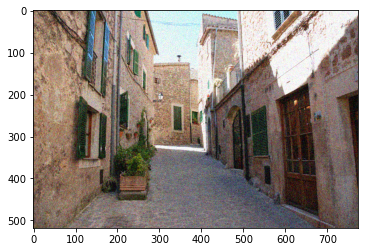

In [3]:
img = plt.imread('FFDNET_IPOL/noisy.png')
plt.imshow(img)
plt.show()

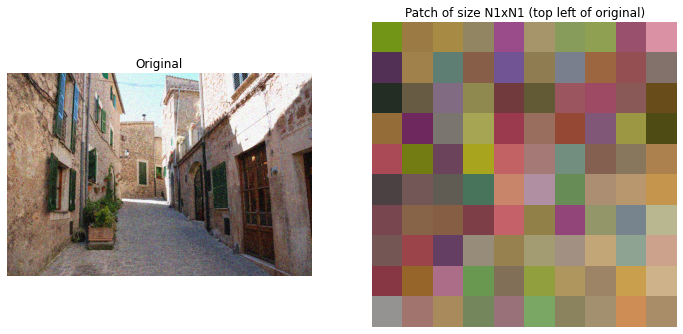

In [4]:
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(img[:10,:10,:])
plt.axis('off')
plt.title('Patch of size N1xN1 (top left of original)')

plt.show()

In [5]:
# Choix des patchs: pas de overlapp sauf dans les coins (ceci pour éviter une quantité trop grandes de patchs pour la matrice de similarité)

def dividing_into_patches(img):
    """Divides an input image into patches of size N1xN1"""
    n, p = img.shape[0], img.shape[1]
    patches = []
    n_10, p_10 = n//10, p//10
    for i in range(n_10+1):
        for j in range(p_10+1):
            if i < n_10 and j < p_10:
                patches.append(img[i*N1:i*N1+10, j*N1:j*N1+10, :])
            elif i == n_10 and j < p_10:
                patches.append(img[n-10:n, j*N1:j*N1+10, :])
            elif i < n_10 and j == p_10:
                patches.append(img[i*N1:i*N1+10, p-10:p, :])
            elif i == n_10 and j == p_10:
                patches.append(img[n-10:n, p-10:p, :])
    return np.array(patches)       

In [6]:
patches = dividing_into_patches(img)
print('There are: ' + str(patches.shape[0]) + ' patches in this image (N = (n//10+1)*(p//10+1))')

There are: 4056 patches in this image (N = (n//10+1)*(p//10+1))


### Similarity Matrix

In [7]:
def similarity_matrix(patches):
    """Computes the similarity matrix between the patches
    Returns a matrix of size N1xN1"""
    size = patches.shape[0]
    similarity = np.zeros((size,size))
    sim = 0

    # similarity computed with the Frobenius norm
    # leave the 0 similarity with itself to make sure every patch will be in S
    for i in range(size):
        for j in range(size):
            sim = np.linalg.norm(patches[i] - patches[j])
            similarity[i][j] = sim
    return similarity      

In [8]:
similarity = similarity_matrix(patches)
print(similarity)

[[0.         3.3834846  3.36762977 ... 3.98874831 4.00399494 3.84481978]
 [3.3834846  0.         3.3212564  ... 4.26994038 4.18441296 4.09139919]
 [3.36762977 3.3212564  0.         ... 3.64392662 3.70970678 3.59715605]
 ...
 [3.98874831 4.26994038 3.64392662 ... 0.         2.3412652  2.55529857]
 [4.00399494 4.18441296 3.70970678 ... 2.3412652  0.         2.37265611]
 [3.84481978 4.09139919 3.59715605 ... 2.55529857 2.37265611 0.        ]]


In [9]:
def building_the_look_up_table(similarity):
    """Builds a dictionnary by taking for each patch, the
    N2 most similar patches (including itself to make sure
    that all patches are in S"""
    S = {}
    n = similarity.shape[0]
    for i in range(n):
        idx = np.argpartition(similarity[i], N2)
        S['patch ' + str(i)] = idx[:N2]
    return S

In [10]:
look_up_table = building_the_look_up_table(similarity)
print(look_up_table['patch 0'])

[3440 3050 3127    0 3748 2974 2896 1783  392 2645 3591 2361 3123 2106
 3288 3515 1315 3434 3043 1694 1395 3826 3207 3206 3516 2490 3909 3129
 3517 1784 1850 2901]


In [73]:
print(patches.shape)

(4056, 10, 10, 3)


## Separating RBG

In [11]:
red_noise = patches[:,:,:,0]
green_noise = patches[:,:,:,1]
blue_noise = patches[:,:,:,2]

In [12]:
print(red_noise.shape)

(4056, 10, 10)


## NLF Filter

In [13]:
def building_gkj_array(patch_ind, look_up_table, patches):
    gkj = np.zeros((N1,N1,N2))
    idx = look_up_table['patch ' + str(patch_ind)]
    for i in range(len(idx)):
        gkj[:,:,i] = patches[idx[i]]
    return gkj

In [14]:
gkj_tilde = building_gkj_array(1, look_up_table, red_noise)
print(len(gkj_tilde[0][0]))

32


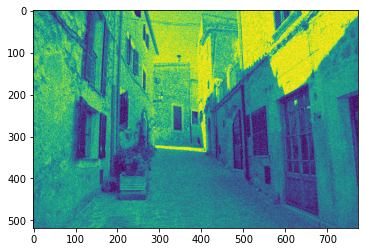

In [33]:
noisy_img = plt.imread('FFDNET_IPOL/noisy.png')
red_noise_img = noisy_img[:,:,0]
green_noise_img = noisy_img[:,:,1]
blue_noise_img = noisy_img[:,:,2]
plt.imshow(red_noise_img)

### Article's Transform

In [15]:
def Gamma(q, tau):
    return q**3/(q**2+tau**2)

In [16]:
#sigma = 30, 50, 75

def reconstruct(tau,coeffs):
    coeffs_rec = [coeffs[0]]
    for i in range(1, len(coeffs)):
        coeffs_rec.append(Gamma(coeffs[i],tau))
    return np.clip(pywt.waverec(coeffs_rec, 'haar'), 0, 255)

In [17]:
# def transform_haar_wavelet(patch_ind,patches,k,sigma):
#     tau_k = (1/4)*sigma/k
#     gkj_tilde = building_gkj_array(patch_ind, look_up_table, patches)
#     a_k, b_k = pywt.dwt(gkj_tilde, 'haar')
#     gam_a_k = Gamma(a_k, tau_k)
#     gam_b_k = Gamma(b_k, tau_k)
#     gkj_hat = pywt.idwt(gam_a_k,gam_b_k, 'haar')
#     return gkj_hat

def transform_haar_wavelet(patch_ind, patches, k, sigma):
    tau_k = (1/4)*sigma/k
    gkj_tilde = building_gkj_array(patch_ind, look_up_table, patches)
    n, p = gkj_tilde.shape[0], gkj_tilde.shape[1]
    gkj_hat = np.zeros_like(gkj_tilde)
    for i in range(n):
        for j in range(p):
            coeffs = pywt.wavedec(gkj_tilde[i,j,:], 'haar', level=2)
            recon = reconstruct(tau_k, coeffs)
            gkj_hat[i,j,:] = recon
    return gkj_hat

In [21]:
sigma = 30
wave_transform = transform_haar_wavelet(1,red_noise,1,sigma)
print(wave_transform.shape)

(10, 10, 32)


In [19]:
def transform_over_all_img(look_up_table,patches,k,sigma):
    n = patches.shape[0]
    transform = []
    for i in range(n):
        gkj_tilde = building_gkj_array(i, look_up_table, patches)
        gkj_hat = transform_haar_wavelet(i,patches,k,sigma)
        transform.append(gkj_hat)
    return np.array(transform)

In [20]:
k = 1
sigma = 30
transform_red = transform_over_all_img(look_up_table,red_noise,k,sigma)
print(transform_red.shape)

(4056, 10, 10, 32)


In [65]:
print(transform_red[0,:,:,12].shape)

(10, 10)


### Image Estimate

In [22]:
# def weight_j(patch_ind, look_up_table, patches, tau):
#     gkj_tilde = building_gkj_array(patch_ind, look_up_table, patches)
#     a_k, b_k = pywt.dwt(gkj_tilde, 'haar')
#     wkj = (np.linalg.norm(a_k**2/(a_k**2+tau**2))**2 + np.linalg.norm(b_k**2/(b_k**2+tau**2))**2)**(-2)
#     return wkj

def weight_j(patch_ind, look_up_table, patches, tau):
    gkj_tilde = building_gkj_array(patch_ind, look_up_table, patches)
    n, p = gkj_tilde.shape[0], gkj_tilde.shape[1]
    summing = 0
    for i in range(n):
        for j in range(p):
            coeffs = pywt.wavedec(gkj_tilde[i,j,:], 'haar', level=2)
            for i in range(len(coeffs)):
                summing = np.linalg.norm(coeffs[i])**2
    wkj = summing/(summing+tau**2)
    return wkj**(-2)

In [23]:
print(weight_j(1, look_up_table, red_noise, 7.5))

217593.42287019352


In [24]:
def all_weights(look_up_table, patches, tau):
    n = patches.shape[0]
    w = []
    for i in range(n):
        w.append(weight_j(i, look_up_table, patches, tau))
    return w

In [25]:
print(len(all_weights(look_up_table, red_noise, 7.5)))

4056


In [26]:
print(patches.shape)

(4056, 10, 10, 3)


In [52]:
# def inverse_look_up_table(patches, look_up_table):
#     inv = {}
#     n = patches.shape[0]
#     for i in range(n):
#         for patch in look_up_table:
#             if i in look_up_table[patch]:
#                 if ('patch '+str(i)) in inv.keys():
#                     inv['patch '+str(i)] += [int(re.findall(r'\d+', patch)[0])]
#                 else: 
#                     inv['patch '+str(i)] = [int(re.findall(r'\d+', patch)[0])]
#     return inv

def inverse_look_up_table(patches, look_up_table):
    inv = {}
    n = patches.shape[0]
    for i in range(n):
        for patch in look_up_table:
            if i in look_up_table[patch]:
                num = int(re.findall(r'\d+', patch)[0])
                if ('patch '+str(i)) in inv.keys():
                    inv['patch '+str(i)] += [(num,np.where(look_up_table[patch] == i)[0][0])]
                else: 
                    inv['patch '+str(i)] = [(num,np.where(look_up_table[patch] == i)[0][0])]
    return inv

In [53]:
inv = inverse_look_up_table(patches, look_up_table)

In [54]:
print(look_up_table['patch 0'])
print(look_up_table['patch 6'])
print(inv['patch 3440'])

[3440 3050 3127    0 3748 2974 2896 1783  392 2645 3591 2361 3123 2106
 3288 3515 1315 3434 3043 1694 1395 3826 3207 3206 3516 2490 3909 3129
 3517 1784 1850 2901]
[3364 2198 2270 1786 2732 1237    6 2276 2423 2361 3440 2188 3593 3047
 2424 1315 2191 1874 2503 1243 3358  392 1818 1706 3607 1952 2974 2347
 2825 3825 1865 3460]
[(0, 0), (6, 10), (11, 24), (78, 27), (249, 13), (314, 16), (318, 25), (390, 25), (393, 5), (396, 16), (431, 20), (448, 28), (468, 22), (473, 22), (549, 24), (551, 27), (552, 10), (555, 26), (626, 8), (860, 8), (862, 20), (867, 18), (876, 8), (944, 20), (1092, 24), (1102, 14), (1193, 23), (1237, 23), (1277, 18), (1315, 6), (1383, 29), (1393, 7), (1493, 21), (1561, 22), (1570, 2), (1639, 10), (1674, 17), (1706, 14), (1745, 1), (1783, 0), (1784, 16), (1787, 24), (1811, 19), (1861, 2), (1862, 17), (1874, 14), (1904, 30), (1908, 21), (1950, 19), (1952, 14), (1982, 27), (2020, 17), (2029, 30), (2058, 15), (2108, 24), (2133, 26), (2138, 7), (2145, 10), (2184, 7), (2188,

In [66]:
# def new_patches(look_up_table, inv, patches, tau, img):
#     weights = all_weights(look_up_table, patches, tau)
#     n, p = img.shape[0], img.shape[1]
#     new_patches = []
#     n_cpt, p_cpt = 0, 0
#     for patch in inv:
#         summing = np.zeros((N1,N1))
#         normalization = 0
#         for pat in inv[patch]:
#             summing += weights[pat]*patches[pat]
#             normalization += weights[pat]
#         new_patches.append(summing / normalization)
#     return np.array(new_patches)

def new_patches(look_up_table, inv, patches, tau, img, k, sigma):
    weights = all_weights(look_up_table, patches, tau)
    n, p = img.shape[0], img.shape[1]
    all_transforms = transform_over_all_img(look_up_table,patches,k,sigma)
    new_patches = []
    for patch in inv:
        summing = np.zeros((N1,N1))
        normalization = 0
        for pat in inv[patch]:
            (ind_patch, position) = pat
            new_patch = all_transforms[ind_patch,:,:,position]
            summing += weights[ind_patch]*new_patch
            normalization += weights[ind_patch]
        new_patches.append(summing / normalization)
    return np.array(new_patches)

In [67]:
k, sigma = 1, 30
new_patch = new_patches(look_up_table, inv, red_noise, 7.5, noisy_img, k, sigma)

In [68]:
print(new_patch.shape)

(4056, 10, 10)


In [69]:
def image_estimate(new_patches, img):
    n, p = img.shape[0], img.shape[1]
    new_image = np.zeros((n, p))
    n_10, p_10 = n//10, p//10
    cpt = 0
    for i in range(n_10+1):
        for j in range(p_10+1):
            if i < n_10 and j < p_10:
                new_image[i*N1:i*N1+N1, j*N1:j*N1+N1] = new_patches[cpt]
            elif i == n_10 and j < p_10:
                new_image[i*N1:n, j*N1:j*N1+N1] = new_patches[cpt][N1-(n-i*N1):,:]
            elif i < n_10 and j == p_10:
                new_image[i*N1:i*N1+N1, j*N1:p] = new_patches[cpt][:,N1-(p-j*N1):]
            elif i == n_10 and j == p_10:
                new_image[i*N1:n, j*N1:p] = new_patches[cpt][N1-(n-i*N1):,N1-(p-j*N1):]
            cpt += 1
    return new_image

In [70]:
img_est = image_estimate(new_patch, noisy_img)

In [71]:
print(img_est)

[[0.47459496 0.58320119 0.53425826 ... 0.95726147 0.95200106 0.95393649]
 [0.44752974 0.54727068 0.49584079 ... 0.97052214 0.95615178 0.95360549]
 [0.39962103 0.48859413 0.53251913 ... 0.96221336 0.93121694 0.96626616]
 ...
 [0.44164631 0.44152533 0.39542755 ... 0.35674608 0.3695935  0.39641119]
 [0.41111015 0.38621412 0.41014037 ... 0.33123853 0.33392306 0.33825254]
 [0.44755735 0.43456195 0.31862814 ... 0.32863293 0.35709418 0.3805116 ]]


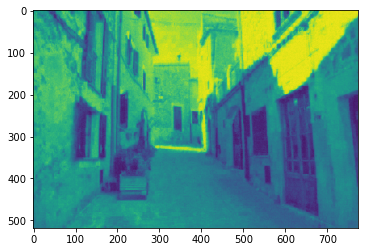

In [72]:
plt.imshow(img_est)
plt.show()